## A basic strain design tutorial using MEWpy

Let's start by loading our model...

In [2]:
from reframed import load_cbmodel
model = load_cbmodel("models/e_coli_core.xml.gz", flavor="bigg")

We will define two optimization objectives:

* Maximize the flux of our target reaction (succinate production)
* Maximize the Biomass-Product Coupled Yield (finds an optimal trade-off between growth and production)

In [3]:
from mewpy.optimization.evaluation import BPCY, TargetFlux
objs = [TargetFlux("R_EX_succ_e"), 
        BPCY(model.biomass_reaction, "R_EX_succ_e")]

Now we define our optimization problem:
* Type of modifications we are searching for (reaction knockouts)
* Environmental conditions (anaerobic growth)

In [4]:
from mewpy.problems import RKOProblem
anaerobic = {'R_EX_o2_e': (0, 0)}
problem = RKOProblem(model, fevaluation=objs, envcond=anaerobic)

And now we can run the optimization an evolutionary algorithm (EA)

In [5]:
from mewpy.optimization import EA
solutions = EA(problem, max_generations=100).run()

Running NSGAII
Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  -0.000000  9.726412  0.000000  0.354781  1.685039|  -0.000000  0.989784  0.000000  0.023263  0.133588|
    200|  -0.000000  9.837897  0.000000  1.129337  2.864062|  0.000000  1.007427  0.000000  0.091571  0.265306|
    300|  -0.000000  9.837897  0.343624  3.329903  4.090460|  0.000000  1.095817  0.000272  0.272208  0.400876|
    400|  0.636194  9.912807  8.390000  7.639787  2.430810|  0.000000  1.095817  0.822084  0.582253  0.407078|
    500|  7.352985  9.912807  9.121247  9.277527  0.378288|  0.000000  1.095817  0.986253  0.779915  0.311338|
    600|  7.266987  9.980334  9.585042  9.435319  0.414442|  0.183047  1.752770  0.897027  0.704145  0.348900|
    700|  7.266987  10.023557  9.585042  9.451748  0.458678|  0.176551  1.752770  0.897027  0.761985  0.380362|
    800|  8.044787  10.023557  9.877849  9.601690  0.471751|  0.176551  1.766529  0.897027  

   7300|  8.362548  15.880998  14.055072  13.189334  2.636419|  0.180063  1.768181  0.994777  0.977886  0.637101|
   7400|  8.362548  15.880998  14.055072  13.203459  2.637895|  0.180063  1.768181  0.994777  0.973432  0.635714|
   7500|  8.362548  15.880998  14.055072  13.203459  2.637895|  0.180063  1.768181  0.994777  0.973432  0.635714|
   7600|  8.362548  15.880998  14.055072  13.203459  2.637895|  0.180063  1.768181  0.994777  0.973432  0.635714|
   7700|  8.362548  15.880998  14.055072  13.203459  2.637895|  0.180063  1.768181  0.994777  0.973432  0.635714|
   7800|  8.362548  15.880998  14.055072  13.185537  2.637300|  0.180063  1.768181  0.994777  0.978103  0.637248|
   7900|  8.362548  15.883427  14.055072  13.263835  2.640594|  0.178657  1.768181  0.994777  0.954871  0.642650|
   8000|  8.362548  15.883427  14.055072  13.203188  2.649363|  0.178657  1.768181  0.994777  0.970165  0.642193|
   8100|  8.362548  15.883427  14.055072  13.203150  2.649324|  0.178657  1.768181  0.99

To make our life easier, let's convert the result to a Pandas DataFrame:

In [7]:
import pandas as pd
get_list = lambda x: [r_id[2:] for r_id in x.values]
table = [[get_list(x), len(get_list(x)), x.fitness[0], x.fitness[1]] for x in solutions]
df = pd.DataFrame(table, columns=["reactions", "knockouts", "target", "BPCY"])

We can now sort the results, for instance by the total number of required knockouts:

In [8]:
df.sort_values("knockouts")

,reactions,knockouts,target,BPCY
66,"[ACALD, THD2, D_LACt2, ATPM, PYRt2]",5,9.818740,1.708042
18,"[ACALD, THD2, GLUDy, D_LACt2, ATPM, PYRt2]",6,9.827161,1.625449
10,"[ACALD, THD2, AKGt2r, D_LACt2, ATPM, PYRt2]",6,9.818740,1.708042
15,"[PYK, ACALD, D_LACt2, ATPM, TKT2, PDH, PYRt2]",7,8.598079,1.765442
30,"[PYK, RPE, ACALD, D_LACt2, ATPM, PDH, PYRt2]",7,8.484277,1.766891
...,...,...,...,...
40,"[PYK, ACALD, THD2, ME1, GLUDy, ATPM, D_LACt2, ...",10,15.839325,0.204101
39,"[PYK, RPE, ACALD, PFL, GLUDy, AKGt2r, ATPM, D_...",10,12.350409,1.426052
35,"[PYK, ACALD, TALA, PFL, ME1, D_LACt2, ATPM, CY...",10,12.249375,1.518255
62,"[PYK, ACALD, PFL, THD2, D_LACt2, AKGt2r, TKT2,...",10,14.055072,0.994777


We can also look at the trade-off of our two objectives (the so-called Pareto front)

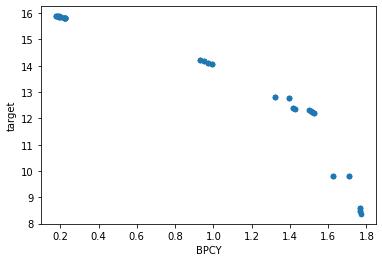

In [9]:
df.plot.scatter("BPCY", "target")